# Artik 47

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import xgboost as xgb

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import ElasticNet, Lasso, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.decomposition import PCA
from sklearn import neighbors

from tqdm import tqdm
from datetime import *
# import catboost as ctb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

C:\Users\alvar\anaconda3\envs\sk_tf_gpu_39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4149881978025889055
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2238919476
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6942619899175006785
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [2]:
PATH_RESULTS = f'~\\Documents\\Artik_47\\Artik-47\\results\\'

In [3]:
def get_data():
    df = pd.read_csv(f'~\Documents\Artik_47\Artik-47\data\GBPUSD_M30.csv', sep='\t', parse_dates=['Time'])
    return df

## Ichimoku Kinko Hyo system

In [14]:
df = get_data()
# Ordena por fecha
df.sort_values(by='Time', inplace=True)
# TIme as index
df.set_index('Time', inplace=True)
## Muestra duplicados en el índice
#df.index.duplicated().sum()
## Muestra cuales son los duplicados
#df[df.index.duplicated(keep=False)]
# Elimina los duplicados
df = df[~df.index.duplicated(keep='first')]
df

,Open,High,Low,Close,Volume
Time,,,,,
2007-01-01 06:00:00,1.95805,1.95836,1.95795,1.95817,1728
2007-01-01 06:30:00,1.95813,1.95835,1.95788,1.95815,1651
2007-01-01 07:00:00,1.95815,1.95832,1.95807,1.95824,1352
2007-01-01 07:30:00,1.95818,1.95833,1.95807,1.95822,1722
2007-01-01 08:00:00,1.95815,1.95871,1.95808,1.95852,1729
...,...,...,...,...,...
2022-07-13 03:30:00,1.18882,1.18885,1.18852,1.18863,596
2022-07-13 04:00:00,1.18858,1.18894,1.18796,1.18813,1522
2022-07-13 04:30:00,1.18811,1.18827,1.18779,1.18794,1852


In [15]:
def calculate_ichimoku(df, tenkan_window=20, kijun_window=60, senkou_window=120):
    """
    Calcula las líneas del indicador Ichimoku Kinko Hyo.

    Parámetros:
    df (pandas.DataFrame): DataFrame con las columnas 'High', 'Low', y 'Close'.
    tenkan_window (int): Número de períodos para el cálculo de Tenkan-Sen (Línea de Conversión). Por defecto: 20
    kijun_window (int): Número de períodos para el cálculo de Kijun-Sen (Línea Base). Por defecto: 60
    senkou_window (int): Número de períodos para el cálculo de Senkou Span B (Segunda Línea Líder). Por defecto: 120

    Retorna:
    df (pandas.DataFrame): DataFrame original con columnas adicionales para cada línea del indicador Ichimoku.
    """
    # Tenkan-Sen (Línea de Conversión)
    high_9 = df['High'].rolling(window=tenkan_window).max()
    low_9 = df['Low'].rolling(window=tenkan_window).min()
    df['tenkan_sen'] = (high_9 + low_9) / 2

    # Kijun-Sen (Línea Base)
    high_26 = df['High'].rolling(window=kijun_window).max()
    low_26 = df['Low'].rolling(window=kijun_window).min()
    df['kijun_sen'] = (high_26 + low_26) / 2

    # Senkou Span A (Primera Línea Líder)
    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(kijun_window)

    # Senkou Span B (Segunda Línea Líder)
    high_52 = df['High'].rolling(window=senkou_window).max()
    low_52 = df['Low'].rolling(window=senkou_window).min()
    df['senkou_span_b'] = ((high_52 + low_52) / 2).shift(senkou_window)

    # Chikou Span (Línea de Retraso)
    df['chikou_span'] = df['Close'].shift(-kijun_window)

    ## Paso 1. ##
    # Agrega una nueva columna que indica si el precio de cierre está por encima o por debajo de la nube
    df['above_cloud'] = (df['Close'] > df[['senkou_span_a', 'senkou_span_b']].max(axis=1)).astype(int)
    df['below_cloud'] = (df['Close'] < df[['senkou_span_a', 'senkou_span_b']].min(axis=1)).astype(int)

    # Agregamos una columna "signal" que resume los resultados.
    # Si el precio de cierre está por encima de la nube, el valor es 1, e indica comprar.
    # Si el precio de cierre está por debajo de la nube, el valor es -1, e indica vender.
    # Si el precio de cierre está dentro de la nube, el valor es 0, e indica no hacer nada.
    df['signal'] = df['above_cloud'] - df['below_cloud']

    # Eliminamos las columnas temporales 'above_cloud' y 'below_cloud'
    df.drop(['above_cloud', 'below_cloud'], axis=1, inplace=True)

    ## Paso 2. ##
    # Agrega una nueva columna que indica si Tenkan-sen cruza Kijun-sen desde abajo (señal de compra)
    df['bullish_cross'] = (df['tenkan_sen'].shift(1) < df['kijun_sen'].shift(1)) & (df['tenkan_sen'] > df['kijun_sen'])

    # Agrega una nueva columna que indica si Tenkan-sen cruza Kijun-sen desde arriba (señal de venta)
    df['bearish_cross'] = (df['tenkan_sen'].shift(1) > df['kijun_sen'].shift(1)) & (df['tenkan_sen'] < df['kijun_sen'])

    # Agregamos una columna "cross_signal" que resume los resultados.
    # Si 'cross_signal' es 1, podría ser una señal de compra.
    # Si 'cross_signal' es -1, podría ser una señal de venta.
    df['cross_signal'] = df['bullish_cross'].astype(int) - df['bearish_cross'].astype(int)

    # Eliminamos las columnas temporales 'bullish_cross' y 'bearish_cross'
    df.drop(['bullish_cross', 'bearish_cross'], axis=1, inplace=True)

    ## Paso 3. ##
    # Agrega una nueva columna que indica si Chikou Span cruza el precio en dirección ascendente (señal de compra)
    df['chikou_cross_up'] = (df['chikou_span'].shift(kijun_window) < df['Close'].shift(kijun_window)) & (df['chikou_span'] > df['Close'].shift(kijun_window))

    # Agrega una nueva columna que indica si Chikou Span cruza el precio en dirección descendente (señal de venta)
    df['chikou_cross_down'] = (df['chikou_span'].shift(kijun_window) > df['Close'].shift(kijun_window)) & (df['chikou_span'] < df['Close'].shift(kijun_window))

    # Agregamos una columna "chikou_signal" que resume los resultados.
    # Si 'chikou_signal' es 1, podría ser una señal de compra.
    # Si 'chikou_signal' es -1, podría ser una señal de venta.
    df['chikou_signal'] = df['chikou_cross_up'].astype(int) - df['chikou_cross_down'].astype(int)

    # Eliminamos las columnas temporales 'chikou_cross_up' y 'chikou_cross_down'
    df.drop(['chikou_cross_up', 'chikou_cross_down'], axis=1, inplace=True)

    ## Paso 4. ##
    # Añade una nueva columna que indica si Senkou Span A está por encima de Senkou Span B (tendencia alcista)
    df['cloud_green'] = (df['senkou_span_a'] > df['senkou_span_b']).astype(int)

    # Añade una nueva columna que indica si Senkou Span B está por encima de Senkou Span A (tendencia bajista)
    df['cloud_red'] = (df['senkou_span_a'] < df['senkou_span_b']).astype(int)

    # Añadimos una columna "cloud_signal" que resume los resultados
    # Si 'cloud_signal' es 1, podría ser una tendencia alcista.
    # Si 'cloud_signal' es -1, podría ser una tendencia bajista.
    df['cloud_signal'] = df['cloud_green'] - df['cloud_red']

    # Eliminamos las columnas temporales 'cloud_green' y 'cloud_red'
    df.drop(['cloud_green', 'cloud_red'], axis=1, inplace=True)

    # Añade una columna de resumen que suma todas las señales
    # Si 'summary_signal' es 4, podría ser una señal de compra.
    # Si 'summary_signal' es -4, podría ser una señal de venta.
    df['summary_signal'] = df['signal'] + df['cross_signal'] + df['chikou_signal'] + df['cloud_signal']

    return df

In [22]:
df_ichi = calculate_ichimoku(df)
df_ichi

,Open,High,Low,Close,Volume,tenkan_sen,kijun_sen,senkou_span_a,senkou_span_b,chikou_span,signal,cross_signal,chikou_signal,cloud_signal,summary_signal
Time,,,,,,,,,,,,,,,
2007-01-01 06:00:00,1.95805,1.95836,1.95795,1.95817,1728,NaN,NaN,NaN,NaN,1.96562,0,0,0,0,0
2007-01-01 06:30:00,1.95813,1.95835,1.95788,1.95815,1651,NaN,NaN,NaN,NaN,1.96379,0,0,0,0,0
2007-01-01 07:00:00,1.95815,1.95832,1.95807,1.95824,1352,NaN,NaN,NaN,NaN,1.96843,0,0,0,0,0
2007-01-01 07:30:00,1.95818,1.95833,1.95807,1.95822,1722,NaN,NaN,NaN,NaN,1.96847,0,0,0,0,0
2007-01-01 08:00:00,1.95815,1.95871,1.95808,1.95852,1729,NaN,NaN,NaN,NaN,1.97258,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-13 03:30:00,1.18882,1.18885,1.18852,1.18863,596,1.187440,1.18614,1.194045,1.19655,NaN,-1,0,0,-1,-2
2022-07-13 04:00:00,1.18858,1.18894,1.18796,1.18813,1522,1.187445,1.18614,1.194045,1.19655,NaN,-1,0,0,-1,-2
2022-07-13 04:30:00,1.18811,1.18827,1.18779,1.18794,1852,1.188710,1.18614,1.194045,1.19655,NaN,-1,0,0,-1,-2


In [ ]:
# TODO: Graficar las líneas del indicador Ichimoku Kinko Hyo y las señales de trading.
# TODO: Agregar los mejores valores para trading, los precios a los que se debería comprar y vender.
# TDDO: Agregar un gráfico de barras que muestre la cantidad de señales de compra y venta.
# TODO: Agregar un gráfico de barras que muestre la cantidad de señales de compra y venta por año.
# TODO: Agregar los resultados de haber realizados esas compras y ventas. (Ganancias y pérdidas)
# TODO: Hacer un optimizador de los mejores parametros para el modelo

In [23]:
def calculate_orders(df, sl_percent=0.01, tp_percent=0.02, transaction_cost=0.001, slippage=0.001, position_size=10000):
    """
    Calcula los precios de las órdenes de límite, stop loss y take profit, teniendo en cuenta los costos de transacción y el deslizamiento.

    Parámetros:
    df (pandas.DataFrame): DataFrame que contiene las columnas 'tenkan_sen' y 'kijun_sen'.
    sl_percent (float): Porcentaje para calcular el precio de la orden de stop loss.
    tp_percent (float): Porcentaje para calcular el precio de la orden de take profit.
    transaction_cost (float): Estimación de los costos de transacción como porcentaje del valor de la operación.
    slippage (float): Estimación del deslizamiento como porcentaje del precio de la orden.
    position_size (int): Tamaño de la posición para cada operación.

    Retorna:
    df (pandas.DataFrame): DataFrame original con nuevas columnas para los precios de las órdenes.
    """
    # Crea una señal de compra cuando Tenkan-Sen cruza por encima de Kijun-Sen
    df['buy_signal'] = (df['tenkan_sen'].shift(1) < df['kijun_sen'].shift(1)) & (df['tenkan_sen'] > df['kijun_sen'])

    # Crea una señal de venta cuando Tenkan-Sen cruza por debajo de Kijun-Sen
    df['sell_signal'] = (df['tenkan_sen'].shift(1) > df['kijun_sen'].shift(1)) & (df['tenkan_sen'] < df['kijun_sen'])

    # Orden de límite de compra al precio de Kijun-Sen más el deslizamiento
    df.loc[df['buy_signal'], 'buy_order'] = df['kijun_sen'] * (1 + slippage)

    # Orden de límite de venta al precio de Kijun-Sen menos el deslizamiento
    df.loc[df['sell_signal'], 'sell_order'] = df['kijun_sen'] * (1 - slippage)

    # Orden de stop loss un cierto porcentaje por debajo del precio de compra más los costos de transacción
    df['buy_sl'] = df['buy_order'] * (1 - sl_percent - transaction_cost)

    # Orden de stop loss un cierto porcentaje por encima del precio de venta más los costos de transacción
    df['sell_sl'] = df['sell_order'] * (1 + sl_percent + transaction_cost)

    # Orden de take profit un cierto porcentaje por encima del precio de compra menos los costos de transacción
    df['buy_tp'] = df['buy_order'] * (1 + tp_percent - transaction_cost)

    # Orden de take profit un cierto porcentaje por debajo del precio de venta menos los costos de transacción
    df['sell_tp'] = df['sell_order'] * (1 - tp_percent - transaction_cost)

    # Tamaño de la posición para cada operación
    df['position_size'] = position_size

    return df



In [24]:
print(df_ichi.index.duplicated().sum())

0


In [33]:
df_orders = calculate_orders(df_ichi)
df_orders

,Open,High,Low,Close,Volume,tenkan_sen,kijun_sen,senkou_span_a,senkou_span_b,chikou_span,...,summary_signal,buy_signal,sell_signal,buy_order,sell_order,buy_sl,sell_sl,buy_tp,sell_tp,position_size
Time,,,,,,,,,,,,,,,,,,,,,
2007-01-01 06:00:00,1.95805,1.95836,1.95795,1.95817,1728,NaN,NaN,NaN,NaN,1.96562,...,0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,10000
2007-01-01 06:30:00,1.95813,1.95835,1.95788,1.95815,1651,NaN,NaN,NaN,NaN,1.96379,...,0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,10000
2007-01-01 07:00:00,1.95815,1.95832,1.95807,1.95824,1352,NaN,NaN,NaN,NaN,1.96843,...,0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,10000
2007-01-01 07:30:00,1.95818,1.95833,1.95807,1.95822,1722,NaN,NaN,NaN,NaN,1.96847,...,0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,10000
2007-01-01 08:00:00,1.95815,1.95871,1.95808,1.95852,1729,NaN,NaN,NaN,NaN,1.97258,...,0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-13 03:30:00,1.18882,1.18885,1.18852,1.18863,596,1.187440,1.18614,1.194045,1.19655,NaN,...,-2,False,False,NaN,NaN,NaN,NaN,NaN,NaN,10000
2022-07-13 04:00:00,1.18858,1.18894,1.18796,1.18813,1522,1.187445,1.18614,1.194045,1.19655,NaN,...,-2,False,False,NaN,NaN,NaN,NaN,NaN,NaN,10000
2022-07-13 04:30:00,1.18811,1.18827,1.18779,1.18794,1852,1.188710,1.18614,1.194045,1.19655,NaN,...,-2,False,False,NaN,NaN,NaN,NaN,NaN,NaN,10000


In [42]:
def calculate_pnl(df, start_date=None, end_date=None, print_log=False):
    position = 0  # Número de unidades de la divisa que poseemos actualmente
    pnl = 0  # Nuestra ganancia o pérdida hasta ahora

    # Si se especifican las fechas de inicio y fin, se filtra el DataFrame
    if start_date is not None and end_date is not None:
        df = df.loc[start_date:end_date]

    for i, row in df.iterrows():
        if row['buy_signal']:
            if print_log: print(f"{i}: Buy signal")
            if row['High'] >= row['buy_order']:  # Se ejecuta la orden de límite de compra
                position += row['position_size']
                if print_log: print(f"{i}: Buy order executed at {row['buy_order']}, position is now {position}")
                if row['Low'] <= row['buy_sl']:  # Se alcanza el stop loss
                    pnl += position * (row['buy_sl'] - row['buy_order'])
                    if print_log: print(f"{i}: Stop loss reached at {row['buy_sl']}, pnl is now {pnl}")
                    position = 0  # Cerramos la posición
                elif row['High'] >= row['buy_tp']:  # Se alcanza el take profit
                    pnl += position * (row['buy_tp'] - row['buy_order'])
                    if print_log: print(f"{i}: Take profit reached at {row['buy_tp']}, pnl is now {pnl}")
                    position = 0  # Cerramos la posición
        elif row['sell_signal']:
            if print_log: print(f"{i}: Sell signal")
            if position > 0:  # Solo vendemos si tenemos posiciones
                if row['Low'] <= row['sell_order']:  # Se ejecuta la orden de límite de venta
                    if print_log: print(f"{i}: Sell order executed at {row['sell_order']}, position is now {position}")
                    if row['High'] >= row['sell_sl']:  # Se alcanza el stop loss
                        pnl += position * (row['sell_order'] - row['sell_sl'])
                        if print_log: print(f"{i}: Stop loss reached at {row['sell_sl']}, pnl is now {pnl}")
                        position = 0  # Cerramos la posición
                    elif row['Low'] <= row['sell_tp']:  # Se alcanza el take profit
                        pnl += position * (row['sell_order'] - row['sell_tp'])
                        if print_log: print(f"{i}: Take profit reached at {row['sell_tp']}, pnl is now {pnl}")
                        position = 0  # Cerramos la posición

    return pnl


In [45]:
calculate_pnl(df_orders, start_date='2022-01-01', end_date='2022-02-01', print_log=True)

2022-01-03 19:30:00: Sell signal
2022-01-04 14:30:00: Buy signal
2022-01-04 14:30:00: Buy order executed at 1.34925791, position is now 10000
2022-01-06 10:30:00: Sell signal
2022-01-06 10:30:00: Sell order executed at 1.354658985, position is now 10000
2022-01-07 07:00:00: Buy signal
2022-01-07 07:00:00: Buy order executed at 1.3544931399999998, position is now 20000
2022-01-11 01:00:00: Sell signal
2022-01-11 07:30:00: Buy signal
2022-01-11 07:30:00: Buy order executed at 1.358101745, position is now 30000
2022-01-14 06:30:00: Sell signal
2022-01-14 06:30:00: Sell order executed at 1.3709976300000002, position is now 30000
2022-01-14 17:00:00: Buy signal
2022-01-14 18:30:00: Sell signal
2022-01-14 18:30:00: Sell order executed at 1.371082545, position is now 30000
2022-01-19 17:00:00: Buy signal
2022-01-19 17:00:00: Buy order executed at 1.362586225, position is now 40000
2022-01-20 18:00:00: Sell signal
2022-01-20 18:00:00: Sell order executed at 1.36044819, position is now 40000
20

0

In [ ]:
# TODO: Gestión del tamaño de la posición: Podrías considerar ajustar el tamaño de tu posición en función de tu saldo disponible o de alguna medida de volatilidad del mercado. O simplemente un porcentaje del saldo disponible.
# TODO: Optimización de los parámetros: Los parámetros como sl_percent, tp_percent, transaction_cost, slippage y position_size se pueden optimizar para maximizar el rendimiento o para alcanzar un equilibrio entre el rendimiento y el riesgo que estés dispuesto a asumir.

In [26]:
# Cuenta el nuemro de señales de compra y venta entre una fecha de inicio y una fecha final
def count_signals(df, start_date=None, end_date=None):
    """
    Cuenta el número de señales de compra y venta entre una fecha de inicio y una fecha final.

    Parámetros:
    df (pandas.DataFrame): DataFrame que contiene las columnas 'buy_signal' y 'sell_signal'.
    start_date (str): Fecha de inicio del conteo en el formato 'AAAA-MM-DD'. Si no se proporciona, se usa el primer índice del DataFrame.
    end_date (str): Fecha final del conteo en el formato 'AAAA-MM-DD'. Si no se proporciona, se usa el último índice del DataFrame.

    Retorna:
    buy_count (int): Número de señales de compra.
    sell_count (int): Número de señales de venta.
    """
    # Si no se proporciona start_date o end_date, se utiliza todo el rango de fechas del DataFrame
    if start_date is None:
        start_date = df.index.min()
    if end_date is None:
        end_date = df.index.max()

    # Selecciona las filas entre start_date y end_date
    df = df.loc[start_date:end_date]

    # Cuenta el número de señales de compra y venta
    buy_count = df['buy_signal'].sum()
    sell_count = df['sell_signal'].sum()

    return buy_count, sell_count


In [29]:
# Cuenta el número de señales de compra y venta entre 2020-01-01 y 2020-12-31
buy_count, sell_count = count_signals(df_orders, start_date='2022-01-01', end_date='2022-12-31')
print(f'Número de señales de compra: {buy_count}')
print(f'Número de señales de venta: {sell_count}')

Número de señales de compra: 59
Número de señales de venta: 58


In [7]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def plot_ichimoku(df, start_date=None, end_date=None):
    """
    Grafica las líneas del indicador Ichimoku Kinko Hyo y las señales de trading.

    Parámetros:
    df (pandas.DataFrame): DataFrame con las columnas de Ichimoku y las señales.
    start_date (str): Fecha de inicio del gráfico en el formato 'AAAA-MM-DD'. Si no se proporciona, se usa el primer índice del DataFrame.
    end_date (str): Fecha final del gráfico en el formato 'AAAA-MM-DD'. Si no se proporciona, se usa el último índice del DataFrame.
    """

    # Si no se proporciona start_date o end_date, se utiliza todo el rango de fechas del DataFrame
    if start_date is None:
        start_date = df.index.min()
    if end_date is None:
        end_date = df.index.max()

    # Selecciona el rango de fechas del DataFrame
    df = df.loc[start_date:end_date]

    # Crea una nueva figura y un conjunto de subtramas
    fig, ax = plt.subplots(figsize=(30,15))

    # Grafica el precio de cierre
    df['Close'].plot(ax=ax, color='black', label='Close')

    # Grafica Tenkan-sen
    df['tenkan_sen'].plot(ax=ax, color='red', label='Tenkan-sen')

    # Grafica Kijun-sen
    df['kijun_sen'].plot(ax=ax, color='blue', label='Kijun-sen')

    # Rellena la nube Ichimoku
    ax.fill_between(df.index, df['senkou_span_a'], df['senkou_span_b'], where=df['senkou_span_a'] > df['senkou_span_b'], color='lightgreen', alpha=0.5)
    ax.fill_between(df.index, df['senkou_span_a'], df['senkou_span_b'], where=df['senkou_span_a'] < df['senkou_span_b'], color='lightcoral', alpha=0.5)

    # Resalta las señales de compra
    buy_signals = df[df['summary_signal'] == 4]
    ax.scatter(buy_signals.index, buy_signals['Close'], color='green', marker='^', s=100)

    # Resalta las señales de venta
    sell_signals = df[df['summary_signal'] == -4]
    ax.scatter(sell_signals.index, sell_signals['Close'], color='red', marker='v', s=100)

    # Crea dos objetos Line2D (lineas sin segmentos) para usarlos en la leyenda
    buy_line = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Buy signal')
    sell_line = mlines.Line2D([], [], color='red', marker='v', linestyle='None', markersize=10, label='Sell signal')

    # Muestra la leyenda
    ax.legend(handles=[buy_line, sell_line], title='Signals')

    # Muestra el gráfico
    plt.show()



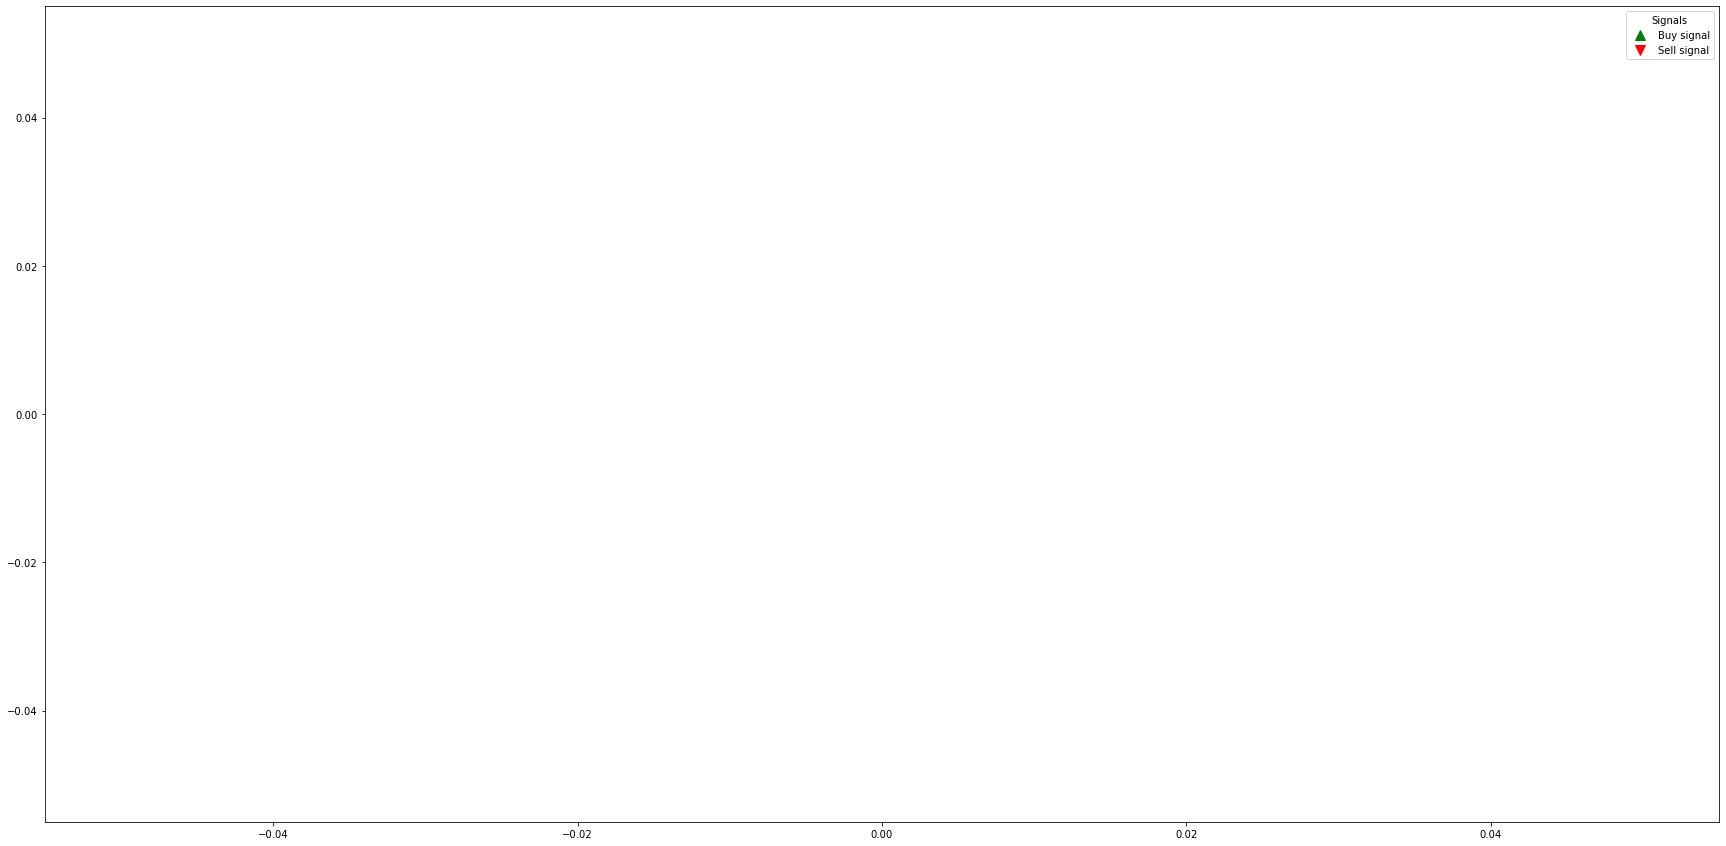

In [8]:
plot_ichimoku(df_ichi, start_date='2019-08-25', end_date='2019-08-30')

In [ ]:
df_ichi

In [ ]:
# Comprobar si hay algún valor no numérico en las columnas
for column in ['Close', 'tenkan_sen', 'kijun_sen', 'senkou_span_a', 'senkou_span_b']:
    print(df_ichi[pd.to_numeric(df[column], errors='coerce').isnull()])

## Data preparation

## Ichimoku Kinko Hyo system

In [9]:
df = get_data()
df

,Time,Open,High,Low,Close,Volume
0,2007-01-01 06:00:00,1.95805,1.95836,1.95795,1.95817,1728
1,2007-01-01 06:30:00,1.95813,1.95835,1.95788,1.95815,1651
2,2007-01-01 07:00:00,1.95815,1.95832,1.95807,1.95824,1352
3,2007-01-01 07:30:00,1.95818,1.95833,1.95807,1.95822,1722
4,2007-01-01 08:00:00,1.95815,1.95871,1.95808,1.95852,1729
...,...,...,...,...,...,...
193895,2022-07-13 03:30:00,1.18882,1.18885,1.18852,1.18863,596
193896,2022-07-13 04:00:00,1.18858,1.18894,1.18796,1.18813,1522
193897,2022-07-13 04:30:00,1.18811,1.18827,1.18779,1.18794,1852
193898,2022-07-13 05:00:00,1.18793,1.18814,1.18744,1.18797,1404


In [25]:
def calculate_ichimoku(df, tenkan_window=20, kijun_window=60, senkou_window=120):
    """
    Calcula las líneas del indicador Ichimoku Kinko Hyo.

    Parámetros:
    df (pandas.DataFrame): DataFrame con las columnas 'High', 'Low', y 'Close'.
    tenkan_window (int): Número de períodos para el cálculo de Tenkan-Sen (Línea de Conversión). Por defecto: 20
    kijun_window (int): Número de períodos para el cálculo de Kijun-Sen (Línea Base). Por defecto: 60
    senkou_window (int): Número de períodos para el cálculo de Senkou Span B (Segunda Línea Líder). Por defecto: 120

    Retorna:
    df (pandas.DataFrame): DataFrame original con columnas adicionales para cada línea del indicador Ichimoku.
    """
    # Tenkan-Sen (Línea de Conversión)
    high_9 = df['High'].rolling(window=tenkan_window).max()
    low_9 = df['Low'].rolling(window=tenkan_window).min()
    df['tenkan_sen'] = (high_9 + low_9) / 2

    # Kijun-Sen (Línea Base)
    high_26 = df['High'].rolling(window=kijun_window).max()
    low_26 = df['Low'].rolling(window=kijun_window).min()
    df['kijun_sen'] = (high_26 + low_26) / 2

    # Senkou Span A (Primera Línea Líder)
    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(kijun_window)

    # Senkou Span B (Segunda Línea Líder)
    high_52 = df['High'].rolling(window=senkou_window).max()
    low_52 = df['Low'].rolling(window=senkou_window).min()
    df['senkou_span_b'] = ((high_52 + low_52) / 2).shift(senkou_window)

    # Chikou Span (Línea de Retraso)
    df['chikou_span'] = df['Close'].shift(-kijun_window)

    ## Paso 1. ##
    # Agrega una nueva columna que indica si el precio de cierre está por encima o por debajo de la nube
    df['above_cloud'] = (df['Close'] > df[['senkou_span_a', 'senkou_span_b']].max(axis=1)).astype(int)
    df['below_cloud'] = (df['Close'] < df[['senkou_span_a', 'senkou_span_b']].min(axis=1)).astype(int)

    # Agregamos una columna "signal" que resume los resultados.
    # Si el precio de cierre está por encima de la nube, el valor es 1, e indica comprar.
    # Si el precio de cierre está por debajo de la nube, el valor es -1, e indica vender.
    # Si el precio de cierre está dentro de la nube, el valor es 0, e indica no hacer nada.
    df['signal'] = df['above_cloud'] - df['below_cloud']

    # Eliminamos las columnas temporales 'above_cloud' y 'below_cloud'
    df.drop(['above_cloud', 'below_cloud'], axis=1, inplace=True)

    ## Paso 2. ##
    # Agrega una nueva columna que indica si Tenkan-sen cruza Kijun-sen desde abajo (señal de compra)
    df['bullish_cross'] = (df['tenkan_sen'].shift(1) < df['kijun_sen'].shift(1)) & (df['tenkan_sen'] > df['kijun_sen'])

    # Agrega una nueva columna que indica si Tenkan-sen cruza Kijun-sen desde arriba (señal de venta)
    df['bearish_cross'] = (df['tenkan_sen'].shift(1) > df['kijun_sen'].shift(1)) & (df['tenkan_sen'] < df['kijun_sen'])

    # Agregamos una columna "cross_signal" que resume los resultados.
    # Si 'cross_signal' es 1, podría ser una señal de compra.
    # Si 'cross_signal' es -1, podría ser una señal de venta.
    df['cross_signal'] = df['bullish_cross'].astype(int) - df['bearish_cross'].astype(int)

    # Eliminamos las columnas temporales 'bullish_cross' y 'bearish_cross'
    df.drop(['bullish_cross', 'bearish_cross'], axis=1, inplace=True)

    ## Paso 3. ##
    # Agrega una nueva columna que indica si Chikou Span cruza el precio en dirección ascendente (señal de compra)
    df['chikou_cross_up'] = (df['chikou_span'].shift(kijun_window) < df['Close'].shift(kijun_window)) & (df['chikou_span'] > df['Close'].shift(kijun_window))

    # Agrega una nueva columna que indica si Chikou Span cruza el precio en dirección descendente (señal de venta)
    df['chikou_cross_down'] = (df['chikou_span'].shift(kijun_window) > df['Close'].shift(kijun_window)) & (df['chikou_span'] < df['Close'].shift(kijun_window))

    # Agregamos una columna "chikou_signal" que resume los resultados.
    # Si 'chikou_signal' es 1, podría ser una señal de compra.
    # Si 'chikou_signal' es -1, podría ser una señal de venta.
    df['chikou_signal'] = df['chikou_cross_up'].astype(int) - df['chikou_cross_down'].astype(int)

    # Eliminamos las columnas temporales 'chikou_cross_up' y 'chikou_cross_down'
    df.drop(['chikou_cross_up', 'chikou_cross_down'], axis=1, inplace=True)

    ## Paso 4. ##
    # Añade una nueva columna que indica si Senkou Span A está por encima de Senkou Span B (tendencia alcista)
    df['cloud_green'] = (df['senkou_span_a'] > df['senkou_span_b']).astype(int)

    # Añade una nueva columna que indica si Senkou Span B está por encima de Senkou Span A (tendencia bajista)
    df['cloud_red'] = (df['senkou_span_a'] < df['senkou_span_b']).astype(int)

    # Añadimos una columna "cloud_signal" que resume los resultados
    # Si 'cloud_signal' es 1, podría ser una tendencia alcista.
    # Si 'cloud_signal' es -1, podría ser una tendencia bajista.
    df['cloud_signal'] = df['cloud_green'] - df['cloud_red']

    # Eliminamos las columnas temporales 'cloud_green' y 'cloud_red'
    df.drop(['cloud_green', 'cloud_red'], axis=1, inplace=True)

    # Añade una columna de resumen que suma todas las señales
    # Si 'summary_signal' es 4, podría ser una señal de compra.
    # Si 'summary_signal' es -4, podría ser una señal de venta.
    df['summary_signal'] = df['signal'] + df['cross_signal'] + df['chikou_signal'] + df['cloud_signal']

    return df

In [69]:
df_ichi = calculate_ichimoku(df)
df_ichi

,Open,High,Low,Close,Volume,tenkan_sen,kijun_sen,senkou_span_a,senkou_span_b,chikou_span,signal,cross_signal,chikou_signal,cloud_signal,summary_signal
Time,,,,,,,,,,,,,,,
2007-01-01 06:00:00,1.95805,1.95836,1.95795,1.95817,1728,NaN,NaN,NaN,NaN,1.96562,0,0,0,0,0
2007-01-01 06:30:00,1.95813,1.95835,1.95788,1.95815,1651,NaN,NaN,NaN,NaN,1.96379,0,0,0,0,0
2007-01-01 07:00:00,1.95815,1.95832,1.95807,1.95824,1352,NaN,NaN,NaN,NaN,1.96843,0,0,0,0,0
2007-01-01 07:30:00,1.95818,1.95833,1.95807,1.95822,1722,NaN,NaN,NaN,NaN,1.96847,0,0,0,0,0
2007-01-01 08:00:00,1.95815,1.95871,1.95808,1.95852,1729,NaN,NaN,NaN,NaN,1.97258,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-13 03:30:00,1.18882,1.18885,1.18852,1.18863,596,1.187440,1.18614,1.194045,1.19655,NaN,-1,0,0,-1,-2
2022-07-13 04:00:00,1.18858,1.18894,1.18796,1.18813,1522,1.187445,1.18614,1.194045,1.19655,NaN,-1,0,0,-1,-2
2022-07-13 04:30:00,1.18811,1.18827,1.18779,1.18794,1852,1.188710,1.18614,1.194045,1.19655,NaN,-1,0,0,-1,-2


In [64]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def plot_ichimoku(df, start_date=None, end_date=None):
    """
    Grafica las líneas del indicador Ichimoku Kinko Hyo y las señales de trading.

    Parámetros:
    df (pandas.DataFrame): DataFrame con las columnas de Ichimoku y las señales.
    start_date (str): Fecha de inicio del gráfico en el formato 'AAAA-MM-DD'. Si no se proporciona, se usa el primer índice del DataFrame.
    end_date (str): Fecha final del gráfico en el formato 'AAAA-MM-DD'. Si no se proporciona, se usa el último índice del DataFrame.
    """

    # Si no se proporciona start_date o end_date, se utiliza todo el rango de fechas del DataFrame
    if start_date is None:
        start_date = df.index.min()
    if end_date is None:
        end_date = df.index.max()

    # Selecciona el rango de fechas del DataFrame
    df = df.loc[start_date:end_date]

    # Crea una nueva figura y un conjunto de subtramas
    fig, ax = plt.subplots(figsize=(30,15))

    # Grafica el precio de cierre
    df['Close'].plot(ax=ax, color='black', label='Close')

    # Grafica Tenkan-sen
    df['tenkan_sen'].plot(ax=ax, color='red', label='Tenkan-sen')

    # Grafica Kijun-sen
    df['kijun_sen'].plot(ax=ax, color='blue', label='Kijun-sen')

    # Rellena la nube Ichimoku
    ax.fill_between(df.index, df['senkou_span_a'], df['senkou_span_b'], where=df['senkou_span_a'] > df['senkou_span_b'], color='lightgreen', alpha=0.5)
    ax.fill_between(df.index, df['senkou_span_a'], df['senkou_span_b'], where=df['senkou_span_a'] < df['senkou_span_b'], color='lightcoral', alpha=0.5)

    # Resalta las señales de compra
    buy_signals = df[df['summary_signal'] == 4]
    ax.scatter(buy_signals.index, buy_signals['Close'], color='green', marker='^', s=100)

    # Resalta las señales de venta
    sell_signals = df[df['summary_signal'] == -4]
    ax.scatter(sell_signals.index, sell_signals['Close'], color='red', marker='v', s=100)

    # Crea dos objetos Line2D (lineas sin segmentos) para usarlos en la leyenda
    buy_line = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Buy signal')
    sell_line = mlines.Line2D([], [], color='red', marker='v', linestyle='None', markersize=10, label='Sell signal')

    # Muestra la leyenda
    ax.legend(handles=[buy_line, sell_line], title='Signals')

    # Muestra el gráfico
    plt.show()



C:\Users\alvar\AppData\Local\Temp\ipykernel_14212\861693201.py:21: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[start_date:end_date]


TypeError: The DTypes <class 'numpy.dtype[float64]'> and <class 'numpy.dtype[datetime64]'> do not have a common DType. For example they cannot be stored in a single array unless the dtype is `object`.

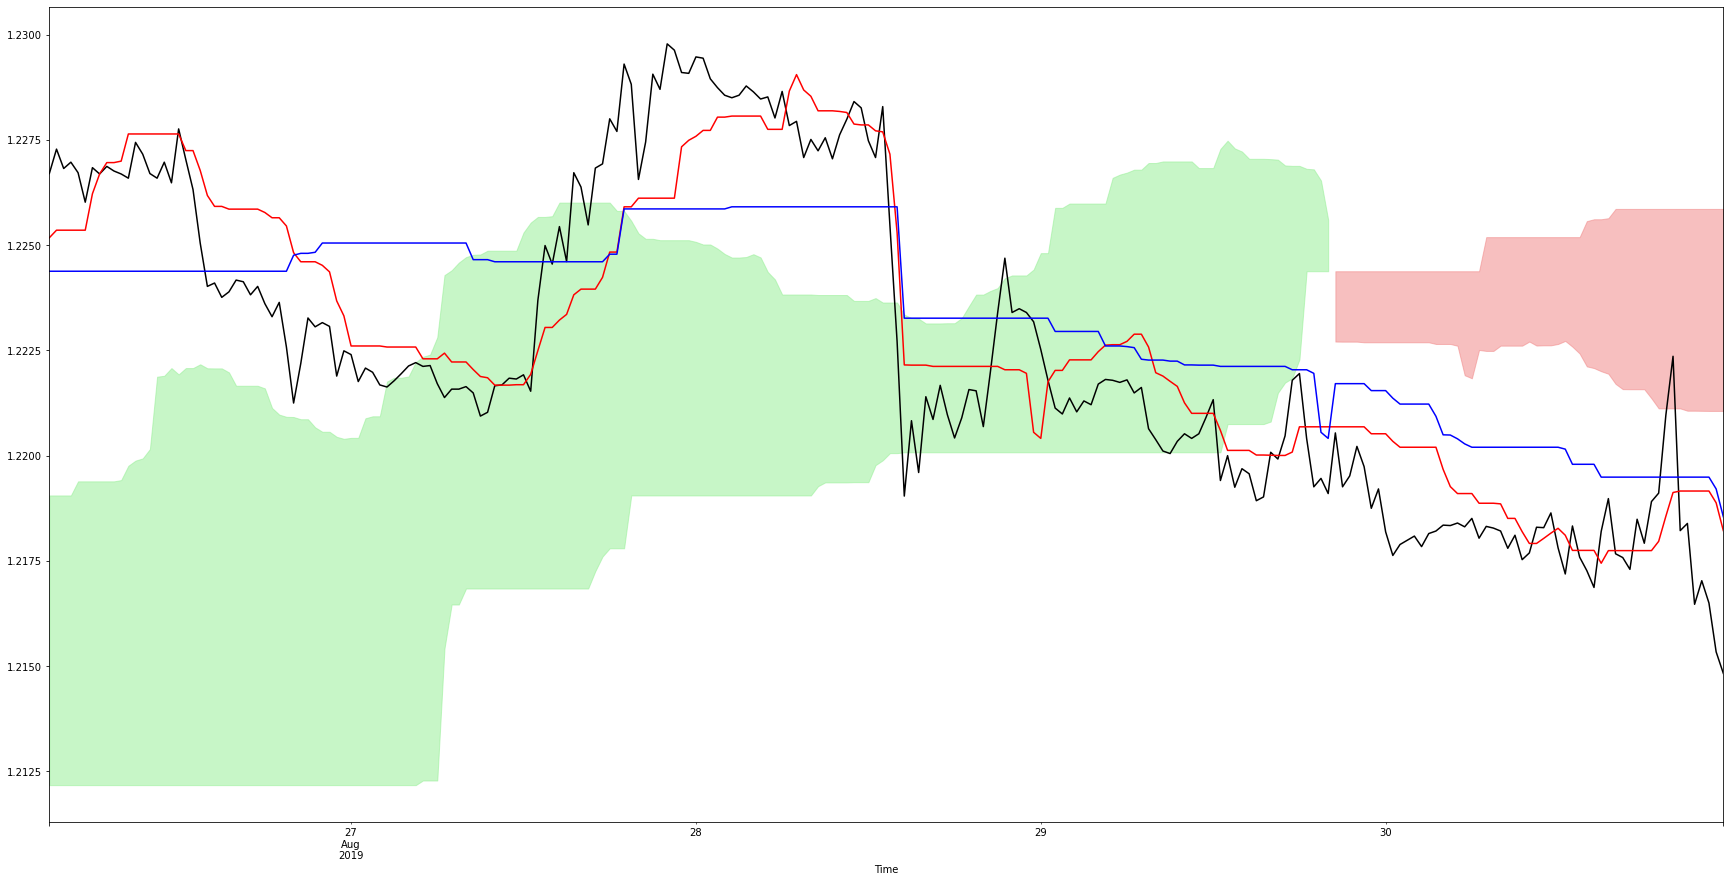

In [65]:
plot_ichimoku(df_ichi, start_date='2019-08-25', end_date='2019-08-30')

In [48]:
df_ichi

,Open,High,Low,Close,Volume,tenkan_sen,kijun_sen,senkou_span_a,senkou_span_b,chikou_span,signal,cross_signal,chikou_signal,cloud_signal,summary_signal
Time,,,,,,,,,,,,,,,
2007-01-01 06:00:00,1.95805,1.95836,1.95795,1.95817,1728,NaN,NaN,NaN,NaN,1.96562,0,0,0,0,0
2007-01-01 06:30:00,1.95813,1.95835,1.95788,1.95815,1651,NaN,NaN,NaN,NaN,1.96379,0,0,0,0,0
2007-01-01 07:00:00,1.95815,1.95832,1.95807,1.95824,1352,NaN,NaN,NaN,NaN,1.96843,0,0,0,0,0
2007-01-01 07:30:00,1.95818,1.95833,1.95807,1.95822,1722,NaN,NaN,NaN,NaN,1.96847,0,0,0,0,0
2007-01-01 08:00:00,1.95815,1.95871,1.95808,1.95852,1729,NaN,NaN,NaN,NaN,1.97258,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-13 03:30:00,1.18882,1.18885,1.18852,1.18863,596,1.187440,1.18614,1.194045,1.19655,NaN,-1,0,0,-1,-2
2022-07-13 04:00:00,1.18858,1.18894,1.18796,1.18813,1522,1.187445,1.18614,1.194045,1.19655,NaN,-1,0,0,-1,-2
2022-07-13 04:30:00,1.18811,1.18827,1.18779,1.18794,1852,1.188710,1.18614,1.194045,1.19655,NaN,-1,0,0,-1,-2


In [67]:
# Comprobar si hay algún valor no numérico en las columnas
for column in ['Close', 'tenkan_sen', 'kijun_sen', 'senkou_span_a', 'senkou_span_b']:
    print(df_ichi[pd.to_numeric(df[column], errors='coerce').isnull()])

Empty DataFrame
Columns: [Open, High, Low, Close, Volume, tenkan_sen, kijun_sen, senkou_span_a, senkou_span_b, chikou_span, signal, cross_signal, chikou_signal, cloud_signal, summary_signal]
Index: []
                        Open     High      Low    Close  Volume  tenkan_sen  \
Time                                                                          
2007-01-01 06:00:00  1.95805  1.95836  1.95795  1.95817    1728         NaN   
2007-01-01 06:30:00  1.95813  1.95835  1.95788  1.95815    1651         NaN   
2007-01-01 07:00:00  1.95815  1.95832  1.95807  1.95824    1352         NaN   
2007-01-01 07:30:00  1.95818  1.95833  1.95807  1.95822    1722         NaN   
2007-01-01 08:00:00  1.95815  1.95871  1.95808  1.95852    1729         NaN   
2007-01-01 08:30:00  1.95845  1.95895  1.95826  1.95877    1524         NaN   
2007-01-01 09:00:00  1.95883  1.95895  1.95871  1.95882    1565         NaN   
2007-01-01 09:30:00  1.95882  1.95895  1.95850  1.95883    1704         NaN   
2007-01-0

## Data preparation

In [3]:
gbpusd = pd.read_csv(f'~\Documents\Artik_47\Artik-47\data\GBPUSD_M30.csv', sep='\t', parse_dates=['Time'])

#Just for close values as objetive
gbpusd = gbpusd[['Time', 'Close', 'Volume']]
gbpusd['Close'] = gbpusd['Close'].round(decimals=4)
gbpusd

,Time,Close,Volume
0,2007-01-01 06:00:00,1.9582,1728
1,2007-01-01 06:30:00,1.9582,1651
2,2007-01-01 07:00:00,1.9582,1352
3,2007-01-01 07:30:00,1.9582,1722
4,2007-01-01 08:00:00,1.9585,1729
...,...,...,...
193895,2022-07-13 03:30:00,1.1886,596
193896,2022-07-13 04:00:00,1.1881,1522
193897,2022-07-13 04:30:00,1.1879,1852
193898,2022-07-13 05:00:00,1.1880,1404


In [4]:
gbpusd.describe()

,Close,Volume
count,193900.000000,193900.000000
mean,1.513250,5233.197968
std,0.215370,11369.920694
min,1.142900,1.000000
25%,1.322375,1562.000000
50%,1.517800,2935.000000
75%,1.613200,5508.000000
max,2.114300,556867.000000


In [5]:
def shift_col(df, col_name, n):
    """
    Shift column in df, n times
    :param df: dataframe
    :param col_name: str
    :param n: int
    :return: dateframe, list columns with shift
    """
    list_shift = []
    for i in range(1,n):
        new_name_col = col_name + '_' + str(i)
        df[new_name_col] = df[col_name].shift(i)
        list_shift.append(new_name_col)

    return df, list_shift

In [6]:
df = gbpusd.copy()
df = df.rename(columns={'Time':'ds'})

#Shift last x values
last_x = 37

df, list_shift = shift_col(df, 'Close', last_x)

#Variance of shift values
df['var_last_val'] = df[list_shift].var(axis=1)

#Shift volume because is impossible to have on time
df, _ = shift_col(df, 'Volume', last_x)
df = df.drop(columns=['Volume'])

df = df.dropna()
df.head()#.iloc[:,2:].values

,ds,Close,Close_1,Close_2,Close_3,Close_4,Close_5,Close_6,Close_7,Close_8,...,Volume_27,Volume_28,Volume_29,Volume_30,Volume_31,Volume_32,Volume_33,Volume_34,Volume_35,Volume_36
36,2007-01-02 00:00:00,1.9582,1.9586,1.9585,1.9582,1.9582,1.9582,1.9584,1.9584,1.9583,...,1358.0,1643.0,1704.0,1565.0,1524.0,1729.0,1722.0,1352.0,1651.0,1728.0
37,2007-01-02 00:30:00,1.9578,1.9582,1.9586,1.9585,1.9582,1.9582,1.9582,1.9584,1.9584,...,1493.0,1358.0,1643.0,1704.0,1565.0,1524.0,1729.0,1722.0,1352.0,1651.0
38,2007-01-02 01:00:00,1.9583,1.9578,1.9582,1.9586,1.9585,1.9582,1.9582,1.9582,1.9584,...,1547.0,1493.0,1358.0,1643.0,1704.0,1565.0,1524.0,1729.0,1722.0,1352.0
39,2007-01-02 01:30:00,1.9582,1.9583,1.9578,1.9582,1.9586,1.9585,1.9582,1.9582,1.9582,...,1579.0,1547.0,1493.0,1358.0,1643.0,1704.0,1565.0,1524.0,1729.0,1722.0
40,2007-01-02 02:00:00,1.9581,1.9582,1.9583,1.9578,1.9582,1.9586,1.9585,1.9582,1.9582,...,1596.0,1579.0,1547.0,1493.0,1358.0,1643.0,1704.0,1565.0,1524.0,1729.0


## Try with FF

In [9]:
df.columns


Index(['ds', 'Close', 'Close_1', 'Close_2', 'Close_3', 'Close_4', 'Close_5',
       'Close_6', 'Close_7', 'Close_8', 'Close_9', 'Close_10', 'Close_11',
       'Close_12', 'Close_13', 'Close_14', 'Close_15', 'Close_16', 'Close_17',
       'Close_18', 'Close_19', 'Close_20', 'Close_21', 'Close_22', 'Close_23',
       'Close_24', 'Close_25', 'Close_26', 'Close_27', 'Close_28', 'Close_29',
       'Close_30', 'Close_31', 'Close_32', 'Close_33', 'Close_34', 'Close_35',
       'Close_36', 'var_last_val', 'Volume_1', 'Volume_2', 'Volume_3',
       'Volume_4', 'Volume_5', 'Volume_6', 'Volume_7', 'Volume_8', 'Volume_9',
       'Volume_10', 'Volume_11', 'Volume_12', 'Volume_13', 'Volume_14',
       'Volume_15', 'Volume_16', 'Volume_17', 'Volume_18', 'Volume_19',
       'Volume_20', 'Volume_21', 'Volume_22', 'Volume_23', 'Volume_24',
       'Volume_25', 'Volume_26', 'Volume_27', 'Volume_28', 'Volume_29',
       'Volume_30', 'Volume_31', 'Volume_32', 'Volume_33', 'Volume_34',
       'Volume_35', 'V

[-6.76091807e-14+0.00000000e+00j  1.25558179e-13+8.19409140e-14j
 -2.24386278e-13+1.82076576e-13j -1.19835206e-13-2.27388883e-13j
 -5.36394684e-14+2.64117086e-14j  1.38746205e-14-1.42893095e-13j
  8.42557232e-14-6.77236045e-14j  3.20283641e-16+1.04844812e-13j
  4.71996809e-14-1.49285511e-14j -1.57905710e-14+1.07063607e-13j
 -2.74158235e-13-5.00000000e+02j  1.22464112e-14-7.32403374e-14j
  3.28469482e-14-6.36495001e-14j  1.25633974e-14+3.38400144e-14j
 -2.37346877e-14+3.60951824e-14j -6.74951785e-14-6.02595948e-15j
  9.23847812e-15-5.02367676e-15j -1.56363276e-13+1.44452859e-13j
 -2.39490874e-13-1.72985846e-13j  9.23488888e-14-1.21500681e-13j
 -1.07841866e-14-2.80861543e-14j -4.59713610e-14-3.37497850e-14j
 -1.91616110e-14-9.06214474e-14j -2.44594868e-14-1.00733863e-13j
 -7.15081007e-14+2.92828776e-14j  7.89476523e-14-1.53034660e-13j
  8.32294143e-14-1.16982520e-13j  2.24497840e-14+7.66413004e-14j
  2.74955379e-14-6.58877994e-14j  2.04917583e-14-4.59598397e-14j
  4.26714844e-14-1.776356

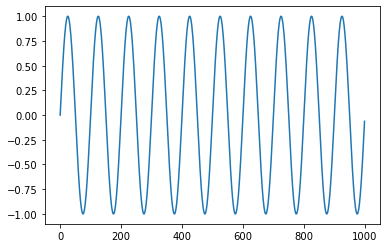

In [21]:
# ejemplo FF

# Crear una señal de prueba

# Frecuencia de muestreo representa la frecuencia de muestreo, es decir, la cantidad de muestras que se toman por segundo para representar una señal analógica.
# En este caso, se está utilizando una frecuencia de muestreo de 1000 Hz, lo que significa que se tomarán 1000 muestras por segundo.
fs = 1000

# frecuencia de la señal (Hz): representa la frecuencia de la señal sinusoidal que se desea crear. En este caso, se está utilizando una frecuencia de 10 Hz.
# Se mide en hercios (Hz), una unidad internacional de medida donde 1 hercio es igual a 1 ciclo por segundo.
f = 10


# vector de tiempo:  se está creando un vector de tiempo que va desde 0 hasta 1 segundo, con un incremento de 1/fs (0.001 segundos). El resultado es un vector de tiempo con 1000 muestras.
t = np.arange(0, 1, 1/fs)

# señal sinusoidal de frecuencia f representa la señal sinusoidal que se desea crear.
# En este caso, se está creando una señal sinusoidal con frecuencia f (10 Hz) utilizando la función np.sin.
# El argumento de la función es 2*np.pi*f*t, que representa el ángulo de la señal sinusoidal en cada punto del vector de tiempo t.
# La señal sinusoidal resultante se guarda en la variable x.
x = np.sin(2*np.pi*f*t)

# En resumen, estas líneas de código crean una señal sinusoidal con una frecuencia de 10 Hz y una duración de 1 segundo, con una frecuencia de muestreo de 1000 Hz.
# La señal resultante se guarda en la variable x. Esta señal se puede utilizar para demostrar el uso de la Transformada Rápida de Fourier (FFT) en Python, tal como se muestra en el ejemplo.


# Plot x
plt.plot(x)

# Aplicar la FFT
# La variable X contiene los coeficientes complejos de la FFT, que representan la amplitud y fase de cada componente de frecuencia en la señal.
X = np.fft.fft(x)

# # Calcular las frecuencias correspondientes a los coeficientes de la FFT
# freqs = np.fft.fftfreq(len(x), 1/fs)
#
# # Graficar la señal en el dominio frecuencial
# plt.plot(freqs, np.abs(X))
# plt.xlabel('Frecuencia (Hz)')
# plt.ylabel('Amplitud')
# plt.show()

In [137]:
# TODO: Find the support and resistance

#Top most frequent values with only 3 decimals
df['Close'].astype(str).str[:4].value_counts()[:10]

1.30    7039
1.56    6743
1.29    6644
1.31    6333
1.61    5880
1.60    5790
1.55    5690
1.59    5078
1.54    4994
1.32    4710
Name: Close, dtype: int64

In [166]:
#Spit
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,2:].values, df.iloc[:,1].values, test_size=0.33, shuffle=False)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train:{y_train.shape}, y_test:{y_test.shape}")

X_train: (129888, 73), X_test: (63976, 73), y_train:(129888,), y_test:(63976,)


## ML  version

In [167]:
pca = PCA().fit(df.iloc[:,2:])
acum=0
for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_ratio_)):
    acum+=var
    print("n:",i+1," VAR:", var, "ACUM:",acum)

n: 1  VAR: 0.6556259397410565 ACUM: 0.6556259397410565
n: 2  VAR: 0.1520670692530078 ACUM: 0.8076930089940644
n: 3  VAR: 0.07708603360487656 ACUM: 0.8847790425989409
n: 4  VAR: 0.013522578095065456 ACUM: 0.8983016206940063
n: 5  VAR: 0.01333578184029602 ACUM: 0.9116374025343024
n: 6  VAR: 0.011824996783963522 ACUM: 0.9234623993182659
n: 7  VAR: 0.01016604070503651 ACUM: 0.9336284400233024
n: 8  VAR: 0.0054301844124912705 ACUM: 0.9390586244357937
n: 9  VAR: 0.004327732247191205 ACUM: 0.9433863566829849
n: 10  VAR: 0.0043259345084433135 ACUM: 0.9477122911914282
n: 11  VAR: 0.00397093710871278 ACUM: 0.951683228300141
n: 12  VAR: 0.003654005189891512 ACUM: 0.9553372334900325
n: 13  VAR: 0.0033091606115968394 ACUM: 0.9586463941016293
n: 14  VAR: 0.002956490340187711 ACUM: 0.9616028844418171
n: 15  VAR: 0.0025824378109120015 ACUM: 0.9641853222527291
n: 16  VAR: 0.0024492253774186182 ACUM: 0.9666345476301478
n: 17  VAR: 0.00232485224489157 ACUM: 0.9689593998750393
n: 18  VAR: 0.00229087812305

In [168]:
#Fecha inicial
inicial_date = '01/01/2017 00:00:00'
inicial_date = datetime.strptime(inicial_date, '%d/%m/%Y %H:%M:%S')
#Fecha final
end_date = '12/07/2022 23:00:00'
end_date = datetime.strptime(end_date, '%d/%m/%Y %H:%M:%S')

#Nombre experimiento
NOM_EXP = 'artik47_ML'

#Variables generales de los modelos
retrain_days = [0]    #Monday is 0 and Sunday is 6
cutoff = 30         #Dias atras del index que se toman para entrenar el modelo en min

In [169]:
def backtest_regression(model_name, fecha_inicio, fecha_fin, data, cutoff, retrain_days, t_scaler, n_pca, params=None):
    # print("from: ", fecha_inicio, " to: ", fecha_fin)

    #Primer entreno
    mask = (data.ds < (fecha_inicio - timedelta(minutes=cutoff)))
    train = data.loc[mask]

    train = train.drop(columns=['ds'])

    val_reales = np.array([])
    val_pred = np.array([])
    val_fechas = np.array([])

    # Divide en variables de entrada y salida
    X, y = train.values[:, 1:], train.values[:, 0].astype('float64')

    #Scalers
    if(t_scaler=='MinMaxScaler'):
        scaler = MinMaxScaler(feature_range=(0, 1))
        X = scaler.fit_transform(X)
    elif(t_scaler=='StandardScaler'):
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    elif(t_scaler=='RobustScaler'):
        scaler = RobustScaler(quantile_range=(0, 95.0))
        X = scaler.fit_transform(X)

    #PCA
    if (type(n_pca) == int):
        pca = PCA(n_components=n_pca)
        X = pca.fit_transform(X)

    #Crea el modelo
    model = eval(model_name + "()")

    #Agrega parametros
    if(params!=None):
        model.set_params(**params)

    model.fit(X, y)

    pbar = tqdm(total=(fecha_fin-fecha_inicio).days+1)
    fecha_index = fecha_inicio
    while(fecha_index <= fecha_fin):
        # print(fecha_index)
        if(fecha_index.weekday() in retrain_days):

            #Re entreno
            mask = (data.ds < (fecha_index - timedelta(days=cutoff)))
            train = data.loc[mask]
            #print("Train: \n", train.iloc[:,0:6], "\n")
            train = train.drop(columns=['ds'])

            # Divide en variables de entrada y salida
            X, y = train.values[:, 1:], train.values[:, 0].astype('float64')

            #Scalers
            if(t_scaler=='MinMaxScaler'):
                scaler = MinMaxScaler(feature_range=(0, 1))
                X = scaler.fit_transform(X)
            elif(t_scaler=='StandardScaler'):
                scaler = StandardScaler()
                X = scaler.fit_transform(X)
            elif(t_scaler=='RobustScaler'):
                scaler = RobustScaler(quantile_range=(0, 95.0))
                X = scaler.fit_transform(X)

            #PCA
            if (type(n_pca) == int):
                pca = PCA(n_components=n_pca)
                X = pca.fit_transform(X)

            model = eval(model_name + "()")

            if(params!=None):
                model.set_params(**params)

            model.fit(X, y)

        mask = (data.ds >= fecha_index) & (data.ds <= fecha_index + timedelta(hours=23))
        to_pred = data.loc[mask]
        if not(to_pred.empty):

            val_fechas = np.append(val_fechas, to_pred.iloc[:,0].tolist())
            #print("to_pred: ", to_pred.values)
            to_pred = to_pred.drop(columns=['ds'])
            # Divide en variables de entrada y salida
            X, y = to_pred.values[:, 1:], to_pred.values[:, 0].astype('float64')

            #Scalers
            if((t_scaler=='MinMaxScaler') or (t_scaler=='StandardScaler') or (t_scaler=='RobustScaler')):
                X = scaler.transform(X)

            #PCA
            if (type(n_pca) == int):
                X = pca.transform(X)

            y_hat = model.predict(X)

            val_reales = np.append(val_reales, y)
            val_pred = np.append(val_pred, y_hat)

        fecha_index = fecha_index + timedelta(days=1)
        pbar.update(1)

    resultados = pd.DataFrame({'fechas':val_fechas, 'val_reales':val_reales, 'val_pred':val_pred})
    pbar.close()
    return resultados

In [170]:
models_dict = {
    'XGBoost0':{'xgb.XGBRegressor':{'n_jobs': 10}, 'Scaler':False, 'PCA':False},
    'XGBoost1':{'xgb.XGBRegressor':{'Objective':'reg:squaredlogerror',
                                   'n_estimator':100,
                                   # 'eval_metric':'mape',
                                   'booster':'gbtree',
                                   'verbosity':0,
                                   # 'disable_default_eval_metric':'false',
                                   'learning_rate':0.2,
                                   'max_depth':7,
                                   'min_child_weight':2,
                                   'sampling_method':'gradient_based',
                                   'n_jobs': 10}, 'Scaler':False, 'PCA':False},
    'ElasticNet':{'ElasticNet':{'alpha':1.0, 'l1_ratio':0.5}},
    'ElasticNet_2':{'ElasticNet':None},
    #'Lasso':{'Lasso':None},
    'RandomForest':{'RandomForestRegressor':{'n_jobs': 4}, 'Scaler':False, 'PCA':False},
    'RandomForest_2':{'RandomForestRegressor':{'n_estimators': 300, 'min_samples_split': 10,
                                            'min_samples_leaf': 1, 'max_features': 'sqrt','max_depth': 40,
                                          'bootstrap': False, 'n_jobs': 10}, 'Scaler':False, 'PCA':False},
    #                'AdaBoost':{'AdaBoostRegressor':None},
    'SVR0':{'SVR':None, 'Scaler':'StandardScaler', 'PCA':5},
    # 'SVR1':{'SVR':None, 'Scaler':'StandardScaler', 'PCA':9},
    # 'SVR2':{'SVR':None, 'Scaler':'StandardScaler', 'PCA':10},
    'HuberRegressor':{'HuberRegressor':{'epsilon':1.0, 'max_iter':200*20, 'alpha':0.0001}, 'Scaler':False, 'PCA':False},
    # 'HuberRegressor1':{'HuberRegressor':None, 'Scaler':'StandardScaler', 'PCA':9},
    'HuberRegressor2':{'HuberRegressor':None, 'Scaler':False, 'PCA':9},
    # 'HuberRegressor2':{'HuberRegressor':{'epsilon':1.0, 'max_iter':200*20, 'alpha':1e-10}, 'Scaler':False, 'PCA':9},
    # 'HuberRegressor3':{'HuberRegressor':None, 'Scaler':'StandardScaler', 'PCA':9},
    # 'HuberRegresso4':{'HuberRegressor':{'epsilon':1.0, 'max_iter':200*20, 'alpha':1e-10}, 'Scaler':'StandardScaler', 'PCA':9},
    # 'HuberRegressor5':{'HuberRegressor':None, 'Scaler':'StandardScaler', 'PCA':9},
    # 'SVR2':{'SVR':None, 'Scaler':'RobustScaler', 'PCA':6},
    #'KNR':{'neighbors.KNeighborsRegressor':None},
    #'BaggingRegressor':{'BaggingRegressor':None},
    #'GradientBoosting':{'GradientBoostingRegressor':None},
}

df_resultados = pd.DataFrame()

for modelo in models_dict.items():
    #print(modelo, type(modelo))
    try:
        output_name_model = modelo[0]
        name_model = list(modelo[1])[0]
        params = modelo[1].get(name_model)
        scaler = modelo[1]['Scaler']
        pca = modelo[1]['PCA']

        start_time = datetime.now()
        print("\n\n--->", output_name_model, '<--- hora inicio:', start_time)
        print("Parametros: ", params, " scaler: ", scaler, " pca: ", pca)
        nombre = output_name_model + '_' + NOM_EXP + '_' + start_time.strftime('%Y_%m_%d-%H_%M') + '.csv'
        print(nombre)
        resultados = backtest_regression(name_model, inicial_date, end_date, df, cutoff, retrain_days,
                                         scaler, pca, params)
        resultados = resultados.round(decimals=4)
        print(resultados)
        print("mean absolute porcentage error:", mean_absolute_percentage_error(resultados['val_reales'], resultados['val_pred'])*100)
        print("mean absolute error:", mean_absolute_error(resultados['val_reales'], resultados['val_pred']))
        # print("root mean square error:", root_mean_square_error(resultados))
        print("tiempo de ejecucion: ", datetime.now() - start_time)
        resultados.to_csv(PATH_RESULTS + nombre, index = False, header=True)

    except Exception as ex:
        print(":::::::::::  Error en " + modelo[0], " ::: ", ex)



---> XGBoost0 <--- hora inicio: 2022-10-02 10:22:03.910818
Parametros:  {'n_jobs': 10}  scaler:  False  pca:  False
XGBoost0_artik47_ML_2022_10_02-10_22.csv


100%|██████████| 2019/2019 [1:35:13<00:00,  2.83s/it]


                   fechas  val_reales  val_pred
0     2017-01-02 04:00:00      1.2316    1.2334
1     2017-01-02 04:30:00      1.2337    1.2327
2     2017-01-02 05:00:00      1.2338    1.2333
3     2017-01-02 05:30:00      1.2343    1.2311
4     2017-01-02 06:00:00      1.2348    1.2334
...                   ...         ...       ...
67461 2022-07-12 21:00:00      1.1908    1.1905
67462 2022-07-12 21:30:00      1.1906    1.1915
67463 2022-07-12 22:00:00      1.1907    1.1921
67464 2022-07-12 22:30:00      1.1910    1.1921
67465 2022-07-12 23:00:00      1.1899    1.1920

[67466 rows x 3 columns]
mean absolute porcentage error: 0.09123156193260293
mean absolute error: 0.0011786010731331341
tiempo de ejecucion:  1:35:29.178767


---> XGBoost1 <--- hora inicio: 2022-10-02 11:57:33.359599
Parametros:  {'Objective': 'reg:squaredlogerror', 'n_estimator': 100, 'booster': 'gbtree', 'verbosity': 0, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 2, 'sampling_method': 'gradient_based', 

100%|██████████| 2019/2019 [1:50:56<00:00,  3.30s/it]


                   fechas  val_reales  val_pred
0     2017-01-02 04:00:00      1.2316    1.2353
1     2017-01-02 04:30:00      1.2337    1.2308
2     2017-01-02 05:00:00      1.2338    1.2353
3     2017-01-02 05:30:00      1.2343    1.2353
4     2017-01-02 06:00:00      1.2348    1.2349
...                   ...         ...       ...
67461 2022-07-12 21:00:00      1.1908    1.1834
67462 2022-07-12 21:30:00      1.1906    1.1931
67463 2022-07-12 22:00:00      1.1907    1.1929
67464 2022-07-12 22:30:00      1.1910    1.1923
67465 2022-07-12 23:00:00      1.1899    1.1923

[67466 rows x 3 columns]
mean absolute porcentage error: 0.08590652519882366
mean absolute error: 0.0011078632199922926
tiempo de ejecucion:  1:51:16.346870
:::::::::::  Error en ElasticNet  :::  'Scaler'
:::::::::::  Error en ElasticNet_2  :::  'Scaler'


---> RandomForest <--- hora inicio: 2022-10-02 13:48:49.957656
Parametros:  {'n_jobs': 4}  scaler:  False  pca:  False
RandomForest_artik47_ML_2022_10_02-13_48.csv


1136it [17:22:24, 55.06s/it]:45:21<22:29:15, 43.78s/it]
 21%|██        | 421/2019 [4:21:29<14:26:16, 32.53s/it]

KeyboardInterrupt: 

In [141]:
df.loc[(df['ds'] >= '2008-01-01 00:00:00') & (df['ds'] <= '2008-01-02 23:00:00')]

,ds,Close,Close_1,Close_2,Close_3,Close_4,Close_5,var_last_val,Volume_1,Volume_2,Volume_3,Volume_4,Volume_5
12516,2008-01-01 00:00:00,1.9821,1.9824,1.9826,1.9840,1.9872,1.9908,1.280000e-05,3833.0,3714.0,9333.0,14286.0,18370.0
12517,2008-01-01 00:30:00,1.9837,1.9821,1.9824,1.9826,1.9840,1.9872,4.448000e-06,2204.0,3833.0,3714.0,9333.0,14286.0
12518,2008-01-01 01:00:00,1.9839,1.9837,1.9821,1.9824,1.9826,1.9840,7.030000e-07,1567.0,2204.0,3833.0,3714.0,9333.0
12519,2008-01-01 01:30:00,1.9847,1.9839,1.9837,1.9821,1.9824,1.9826,6.530000e-07,1336.0,1567.0,2204.0,3833.0,3714.0
12520,2008-01-01 02:00:00,1.9848,1.9847,1.9839,1.9837,1.9821,1.9824,1.178000e-06,1165.0,1336.0,1567.0,2204.0,3833.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12606,2008-01-02 21:00:00,1.9806,1.9784,1.9786,1.9798,1.9807,1.9818,2.048000e-06,16191.0,18928.0,15231.0,18075.0,11442.0
12607,2008-01-02 21:30:00,1.9791,1.9806,1.9784,1.9786,1.9798,1.9807,1.172000e-06,19885.0,16191.0,18928.0,15231.0,18075.0
12608,2008-01-02 22:00:00,1.9806,1.9791,1.9806,1.9784,1.9786,1.9798,8.200000e-07,12797.0,19885.0,16191.0,18928.0,15231.0
12609,2008-01-02 22:30:00,1.9821,1.9806,1.9791,1.9806,1.9784,1.9786,1.148000e-06,21229.0,12797.0,19885.0,16191.0,18928.0
